In [9]:
# Import statements
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import json
import sys
import os

In [10]:
# Creating images directory
if not os.path.exists("images"):
    os.makedirs("images")

In [11]:
# Import file paths

logdir = "~/MLC_experiment_data"
logdir = "project-ruochen"

# 9-24-2023, repeat 5, epoch 200, early stopping
early_5_mlperf_file = f"{logdir}/9-24-mlperf_cloudmask_200.log"
early_5_cloudmask_file = f"{logdir}/9-24-cloudmask_200.log"

# 9-26-2023, repeat 5, epoch 200, no early stopping
noearly_5_mlperf_file = f"{logdir}/9-26-mlperf_cloudmask_200.log"
noearly_5_cloudmask_file = f"{logdir}/9-26-cloudmask_200.log"

# 10-1-2023, repeat 10, epoch 200, early stopping
early_10_mlperf_file = f"{logdir}/10-1-mlperf_cloudmask_200.log"
early_10_cloudmask_file = f"{logdir}/10-1-cloudmask_200.log"

# 9-29-2023, repeat 10, epoch 200, no early stopping
noearly_10_mlperf_file = f"{logdir}/9-29-mlperf_cloudmask_200.log"
noearly_10_cloudmask_file = f"{logdir}/9-29-cloudmask_200.log"


# 6-28-2023, repeat 5, epoch 200, early stopping, by Varshitha
var_mlperf_file = f"{logdir}/varshitha-6-28-mlperf_cloudmask_final.log"
var_cloudmask_file = f"{logdir}/varshitha-6-28-cloudmask_final.log"

In [12]:
def readfile(filename):
    with open(path_expand(filename), 'r') as f:
        content = f.read()
    return content

def path_expand(text):
    result = os.path.expandvars(os.path.expanduser(text))

    # template = Template(text)
    # result = template.substitute(os.environ)

    if result.startswith("."):
        result = result.replace(".", os.getcwd(), 1)

    return result

In [13]:
# Saving figure in different formats
def export_figure(plot, figure_name):
    plot.figure.savefig("images/" + figure_name + ".svg")
    plot.figure.savefig("images/" + figure_name + ".png", dpi=300)
    plot.figure.savefig("images/" + figure_name + ".pdf")

In [14]:
def generate_dataframe(content, train_df, test_df, test_df_raw):
    run = 0
    
    # Appending accuracies to the dataframe
    for line in content:
        # Locate Result line
        if ':::MLLOG' in line and '"key": "result"' in line and 'training' in line:
            # String to a dict using json.loads
            d = json.loads(line.split(":::MLLOG ")[1])
            #print(d)

            # Extracting values
            train_acc = d["value"]["training"]["history"]["accuracy"]
            train_loss = d["value"]["training"]["history"]["loss"]
            val_acc = d["value"]["training"]["history"]["val_accuracy"]
            val_loss = d["value"]["training"]["history"]["val_loss"]
            test_acc = d["value"]["inference"]["avg_accuracy"]
            test_acc_raw = d["value"]["inference"]["accuracy"]

            # print(len(test_acc_raw))

            # Checking length of the lists
            epochs = len(train_acc)
            # print(train_acc)
            if epochs == len(train_loss) and epochs == len(val_acc) and epochs == len(val_loss):
                # Appending to dataframe
                for i in range(epochs):
                    is_last_epoch = "True" if i==(epochs-1) else "False"
                    train_df.loc[len(train_df.index)] = ["#" + str(run+1), i+1, is_last_epoch, train_acc[i], train_loss[i], val_acc[i], val_loss[i], test_acc]

                test_df.loc[len(test_df.index)] = ["#" + str(run+1), int(epochs), test_acc]            
            else:
                print("The values for accuracies and losses don't have same length.")

            #Get raw inference (test) accuracies
            for j in range(len(test_acc_raw)):
                test_df_raw.loc[len(test_df_raw.index)] = ["#" + str(run+1), j+1, test_acc_raw[j]]

            run+=1
    return (train_df, test_df, test_df_raw)

In [15]:
def extract_data_create_dataframe(mlperf_file):
    content = readfile(mlperf_file).splitlines()
    
    train_df = pd.DataFrame(columns = ['Experiment ID','Epoch','Last Epoch','Train Accuracy','Train Loss','Validation Accuracy','Validation Loss', 'Avg Test Accuracy'])
    test_df = pd.DataFrame(columns = ['Experiment ID','Epochs', 'Avg Test Accuracy'])
    test_df_raw = pd.DataFrame(columns = ['Experiment ID', 'Test-Image Index', 'Test Raw Accuracy'])
    
    return generate_dataframe(content, train_df, test_df, test_df_raw)

In [16]:
early_5_train_df, early_5_test_df, early_5_test_df_raw = extract_data_create_dataframe(early_5_mlperf_file)
noearly_5_train_df, noearly_5_test_df, noearly_5_test_df_raw = extract_data_create_dataframe(noearly_5_mlperf_file)
early_10_train_df, early_10_test_df, early_10_test_df_raw = extract_data_create_dataframe(early_10_mlperf_file)
noearly_10_train_df, noearly_10_test_df, noearly_10_test_df_raw = extract_data_create_dataframe(noearly_10_mlperf_file)
var_train_df, var_test_df, var_test_df_raw = extract_data_create_dataframe(var_mlperf_file)

In [17]:
noearly_10_test_df_raw

,Experiment ID,Test-Image Index,Test Raw Accuracy
0,#1,1,0.905682
1,#1,2,0.865404
2,#1,3,0.917304
3,#1,4,0.844605
4,#1,5,0.926503
...,...,...,...
995,#10,96,0.789693
996,#10,97,0.898053
997,#10,98,0.909956
998,#10,99,0.938139


In [18]:
# Generate Leaderboard
def generate_leaderboard(train_df, user, date, early_stoppage, patience):
    if not early_stoppage:
        patience = "n/a"
        
    leaderboard = train_df.copy()
    n_rows = leaderboard.shape[0]
    user = [user for i in range(n_rows)]
    date = [date for i in range(n_rows)]
    early_stoppage = [early_stoppage for i in range(n_rows)]
    early_stoppage_patience = [patience for i in range(n_rows)]
    
    experiment_info = pd.DataFrame({'User':user, 'Date':date, 'Early Stoppage':early_stoppage, 'Early Stoppage Patience': early_stoppage_patience})
    
    # Append the columns in training_leaderboard
    leaderboard = pd.concat([experiment_info, leaderboard], axis=1)
    
    return leaderboard

In [19]:
early_5_leaderboard = generate_leaderboard(early_5_train_df, "RG", "9-24-2023", "True", "25")
noearly_5_leaderboard = generate_leaderboard(noearly_5_train_df, "RG", "9-26-2023", "False", "n/a")
early_10_leaderboard = generate_leaderboard(early_10_train_df, "RG", "10-1-2023", "True", "25")
noearly_10_leaderboard = generate_leaderboard(noearly_10_train_df, "RG", "9-29-2023", "False", "n/a")
var_leaderboard = generate_leaderboard(var_train_df, "VC", "6-28-2023", "True", "25")

In [20]:
early_10_leaderboard

,User,Date,Early Stoppage,Early Stoppage Patience,Experiment ID,Epoch,Last Epoch,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Avg Test Accuracy
0,RG,10-1-2023,True,25,#1,1,False,0.793329,0.432116,0.748922,0.432842,0.891209
1,RG,10-1-2023,True,25,#1,2,False,0.798853,0.390052,0.756986,0.402501,0.891209
2,RG,10-1-2023,True,25,#1,3,False,0.804978,0.386252,0.763607,0.488436,0.891209
3,RG,10-1-2023,True,25,#1,4,False,0.807665,0.380785,0.780324,0.392083,0.891209
4,RG,10-1-2023,True,25,#1,5,False,0.807481,0.377811,0.785043,0.471119,0.891209
...,...,...,...,...,...,...,...,...,...,...,...,...
1757,RG,10-1-2023,True,25,#10,156,False,0.896073,0.237614,0.875257,0.267816,0.892769
1758,RG,10-1-2023,True,25,#10,157,False,0.896465,0.237552,0.874437,0.274154,0.892769
1759,RG,10-1-2023,True,25,#10,158,False,0.896077,0.238392,0.888649,0.256811,0.892769
1760,RG,10-1-2023,True,25,#10,159,False,0.895605,0.238467,0.881117,0.263229,0.892769


In [21]:
# Compare Ruochen's early stopping with Varshitha's early stopping, where we only take the last value
RG_early_vs_Var_early_leaderboard = pd.concat([early_5_leaderboard, early_10_leaderboard, var_leaderboard], ignore_index=True)

# Compare Ruochen's non early stopping with Varshitha's early stopping, where we only take the last value
RG_noearly_vs_Var_early_leaderboard = pd.concat([noearly_5_leaderboard, noearly_10_leaderboard, var_leaderboard], ignore_index=True)

# Compare Ruochen's early stopping with Ruochen's non early stopping, where we only take the last value
RG_early_vs_RG_noearly_leaderboard = pd.concat([early_5_leaderboard, early_10_leaderboard, noearly_5_leaderboard, noearly_10_leaderboard], ignore_index=True)

# Compare Ruochen's early stopping and non early stopping with Varshitha's early stopping, where we only take the last value
RG_early_noearly_vs_Var_early_leaderboard = pd.concat([early_5_leaderboard, early_10_leaderboard, noearly_5_leaderboard, noearly_10_leaderboard, var_leaderboard], ignore_index=True)

# Master Training Leaderboard
master_training_leaderboard = pd.concat([early_5_leaderboard, early_10_leaderboard, noearly_5_leaderboard, noearly_10_leaderboard, var_leaderboard], ignore_index=True)

In [22]:
# Taking the last epoch's data on leaderboards
RG_early_vs_Var_early_leaderboard_lastepoch = RG_early_vs_Var_early_leaderboard[RG_early_vs_Var_early_leaderboard["Last Epoch"]=="True"]
RG_noearly_vs_Var_early_leaderboard_lastepoch = RG_noearly_vs_Var_early_leaderboard[RG_noearly_vs_Var_early_leaderboard["Last Epoch"]=="True"]
RG_early_vs_RG_noearly_leaderboard_lastepoch = RG_early_vs_RG_noearly_leaderboard[RG_early_vs_RG_noearly_leaderboard["Last Epoch"]=="True"]
RG_early_noearly_vs_Var_early_leaderboard_lastepoch = RG_early_noearly_vs_Var_early_leaderboard[RG_early_noearly_vs_Var_early_leaderboard["Last Epoch"]=="True"]

In [23]:
RG_early_noearly_vs_Var_early_leaderboard_lastepoch

,User,Date,Early Stoppage,Early Stoppage Patience,Experiment ID,Epoch,Last Epoch,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Avg Test Accuracy
107,RG,9-24-2023,True,25,#1,108,True,0.893982,0.242904,0.877932,0.271016,0.888595
261,RG,9-24-2023,True,25,#2,154,True,0.895007,0.238510,0.884290,0.260860,0.891453
425,RG,9-24-2023,True,25,#3,164,True,0.908306,0.210404,0.888095,0.254709,0.892463
585,RG,9-24-2023,True,25,#4,160,True,0.909115,0.207497,0.890675,0.243213,0.889012
785,RG,9-24-2023,True,25,#5,200,True,0.898268,0.231289,0.890286,0.248710,0.894261
967,RG,10-1-2023,True,25,#1,182,True,0.896299,0.237628,0.881965,0.261715,0.891209
1134,RG,10-1-2023,True,25,#2,167,True,0.893473,0.240438,0.881808,0.267651,0.890255
1286,RG,10-1-2023,True,25,#3,152,True,0.894737,0.239340,0.889598,0.256993,0.891249
1485,RG,10-1-2023,True,25,#4,199,True,0.898612,0.231376,0.892824,0.256353,0.893220
1654,RG,10-1-2023,True,25,#5,169,True,0.896271,0.236913,0.883514,0.266985,0.887244


In [24]:
# Create ranking based on Train Accuracy/Loss, Validation Accuracy/Loss, and Test Accuracy
def tag_ranking_to_leaderboard(leaderboard):
    board = leaderboard.copy()
    
    board = board.sort_values(by="Train Accuracy",ascending=False)
    board['Train Accuracy Rank'] = range(1,len(board)+1)

    board = board.sort_values(by="Train Loss",ascending=True)
    board['Train Loss Rank'] = range(1,len(board)+1)

    board = board.sort_values(by="Validation Accuracy",ascending=False)
    board['Validation Accuracy Rank'] = range(1,len(board)+1)

    board = board.sort_values(by="Validation Loss",ascending=True)
    board['Validation Loss Rank'] = range(1,len(board)+1)
    
    board = board.sort_values(by="Avg Test Accuracy",ascending=False)
    board['Test Accuracy Rank'] = range(1,len(board)+1)

    return board

In [25]:
_RG_early_vs_Var_early_leaderboard_lastepoch = tag_ranking_to_leaderboard(RG_early_vs_Var_early_leaderboard_lastepoch)
_RG_noearly_vs_Var_early_leaderboard_lastepoch = tag_ranking_to_leaderboard(RG_noearly_vs_Var_early_leaderboard_lastepoch)
_RG_early_vs_RG_noearly_leaderboard_lastepoch = tag_ranking_to_leaderboard(RG_early_vs_RG_noearly_leaderboard_lastepoch)
_RG_early_noearly_vs_Var_early_leaderboard_lastepoch = tag_ranking_to_leaderboard(RG_early_noearly_vs_Var_early_leaderboard_lastepoch)

In [26]:
_RG_early_noearly_vs_Var_early_leaderboard_lastepoch.drop(columns=["Early Stoppage Patience"])

,User,Date,Early Stoppage,Experiment ID,Epoch,Last Epoch,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Avg Test Accuracy,Train Accuracy Rank,Train Loss Rank,Validation Accuracy Rank,Validation Loss Rank,Test Accuracy Rank
5894,VC,6-28-2023,True,#2,147,True,0.908647,0.210125,0.884523,0.260072,0.896051,4,4,25,23,1
1854,RG,10-1-2023,True,#6,200,True,0.899977,0.227692,0.892281,0.252617,0.894974,6,6,7,6,2
785,RG,9-24-2023,True,#5,200,True,0.898268,0.231289,0.890286,0.248710,0.894261,12,10,12,3,3
5147,RG,9-29-2023,False,#8,200,True,0.894642,0.241043,0.884783,0.264009,0.893979,32,33,24,28,4
3947,RG,9-29-2023,False,#2,200,True,0.897406,0.233560,0.893031,0.256018,0.893250,19,16,3,12,5
1485,RG,10-1-2023,True,#4,199,True,0.898612,0.231376,0.892824,0.256353,0.893220,10,11,5,14,6
2547,RG,10-1-2023,True,#10,160,True,0.896692,0.236514,0.880844,0.262953,0.892769,25,26,32,26,7
2387,RG,10-1-2023,True,#9,200,True,0.899230,0.230910,0.887800,0.256358,0.892712,7,7,23,15,8
4347,RG,9-29-2023,False,#4,200,True,0.897882,0.233137,0.892873,0.251961,0.892479,14,15,4,5,9
425,RG,9-24-2023,True,#3,164,True,0.908306,0.210404,0.888095,0.254709,0.892463,5,5,22,10,10


In [27]:
# master = master.drop(columns=['Run'])

# latex_table = master.head(20).to_latex()
# latex_output_file = "a.tex"
# with open(latex_output_file, "w") as f:  
#     f.write(latex_table)
# print(latex_table)

In [28]:
# For Graph

# early_5_train_df, early_5_test_df, early_5_test_df_raw = extract_data_create_dataframe(early_5_mlperf_file)
# noearly_5_train_df, noearly_5_test_df, noearly_5_test_df_raw = extract_data_create_dataframe(noearly_5_mlperf_file)
# early_10_train_df, early_10_test_df, early_10_test_df_raw = extract_data_create_dataframe(early_5_mlperf_file)
# noearly_10_train_df, noearly_10_test_df, noearly_10_test_df_raw = extract_data_create_dataframe(noearly_10_mlperf_file)
# var_train_df, var_test_df, var_test_df_raw = extract_data_create_dataframe(var_mlperf_file)

In [29]:
# Line Graph 1: Train & Validation Accuracy vs. Epoch
def line_graph1(train_df):
    acc_plot = sns.lineplot(data = train_df , x = "Epoch", y = "Train Accuracy", label = "Train Accuracy")
    acc_plot = sns.lineplot(data = train_df , x = "Epoch", y = "Validation Accuracy", label = "Validation Accuracy")
    acc_plot.set(xlabel = "Epoch", ylabel = "Accuracies")
    title = "Train & Validation Accuracy vs. Epoch"
    acc_plot.set_title(title)

    # export_figure(acc_plot, title)

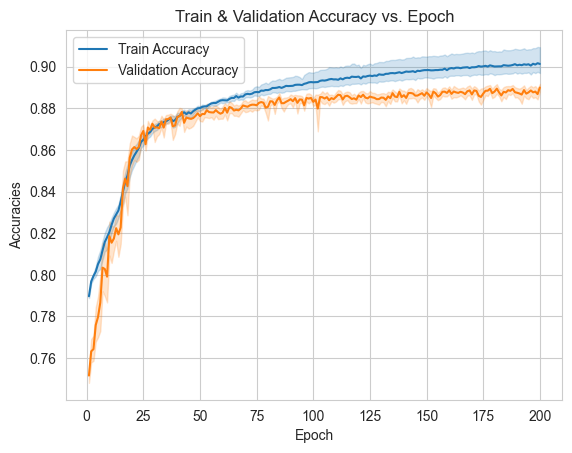

In [30]:
line_graph1(noearly_10_train_df)

In [31]:
# Line Graph 2: Train & Validation Loss vs. Epoch
def line_graph2(train_df):
    loss_plot = sns.lineplot(data = train_df , x = "Epoch", y = "Train Loss", label = "Train Loss")
    loss_plot = sns.lineplot(data = train_df , x = "Epoch", y = "Validation Loss", label = "Validation Loss")
    loss_plot.set(xlabel = "Epochs", ylabel = "Losses")
    title = "Train & Validation Loss vs. Epoch"
    loss_plot.set_title(title)

    # save_figure(loss_plot, title)

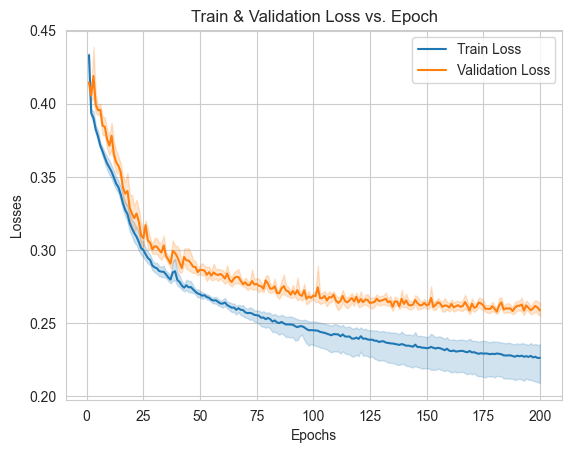

In [32]:
line_graph2(noearly_10_train_df)

In [33]:
# Line Graph 1 Train Diff: Train Accuracy vs. Epoch (Runs Separated)
def line_graph1_train_diff(train_df):
    sns.color_palette("pastel")
    plot = sns.lineplot(data = train_df, y = "Train Accuracy", x = "Epoch", hue = "Experiment ID", palette="pastel")
    plot.set(xlabel = "Epochs", ylabel = "Train Accuracy")
    
    title = "Train Accuracy vs. Epoch (Runs Separated)"
    plot.set_title(title)

    # export_figure(plot, title)

In [34]:
# Line Graph 1 Validation Diff: Validation Accuracy vs. Epoch (Runs Separated)
def line_graph1_val_diff(train_df):
    sns.color_palette("pastel")
    plot = sns.lineplot(data = train_df, y = "Validation Accuracy", x = "Epoch", hue = "Experiment ID", palette="pastel")
    plot.set(xlabel = "Epochs", ylabel = "Validation Accuracy")
    
    title = "Validation Accuracy vs. Epoch (Runs Separated)"
    plot.set_title(title)

    # export_figure(plot, title)

In [35]:
# Line Graph 2 Train Diff: Train Loss vs. Epoch (Runs Separated)
def line_graph2_train_diff(train_df):
    sns.color_palette("pastel")
    plot = sns.lineplot(data = train_df, y = "Train Loss", x = "Epoch", hue = "Experiment ID", palette="pastel")
    plot.set(xlabel = "Epochs", ylabel = "Train Loss")
    
    title = "Train Loss vs. Epoch (Runs Separated)"
    plot.set_title(title)

    # export_figure(plot, title)

In [36]:
# Line Graph 2 Validation Diff: Validation Loss vs. Epoch (Runs Separated)
def line_graph2_val_diff(train_df):
    sns.color_palette("pastel")
    plot = sns.lineplot(data = train_df, y = "Validation Loss", x = "Epoch", hue = "Experiment ID", palette="pastel")
    plot.set(xlabel = "Epochs", ylabel = "Validation Loss")
    
    title = "Validation Loss vs. Epoch (Runs Separated)"
    plot.set_title(title)

    # export_figure(plot, title)

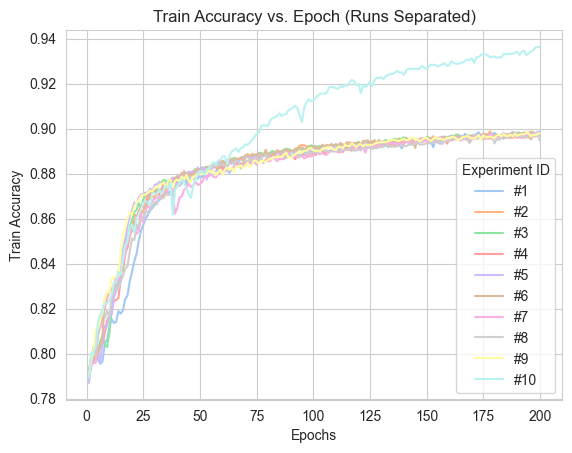

In [37]:
line_graph1_train_diff(noearly_10_train_df)

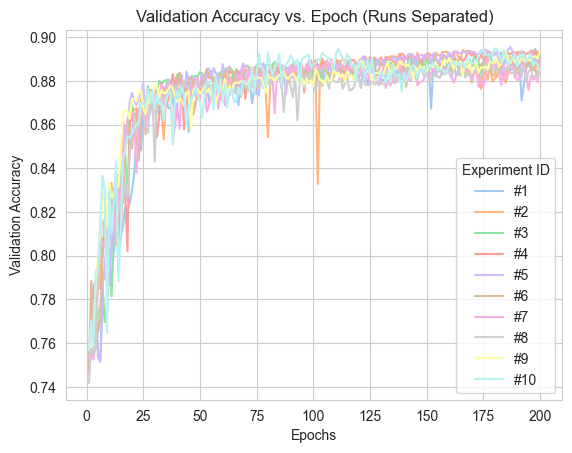

In [38]:
line_graph1_val_diff(noearly_10_train_df)

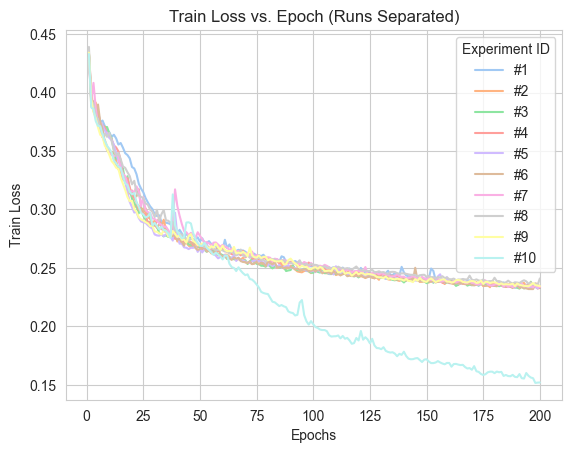

In [39]:
line_graph2_train_diff(noearly_10_train_df)

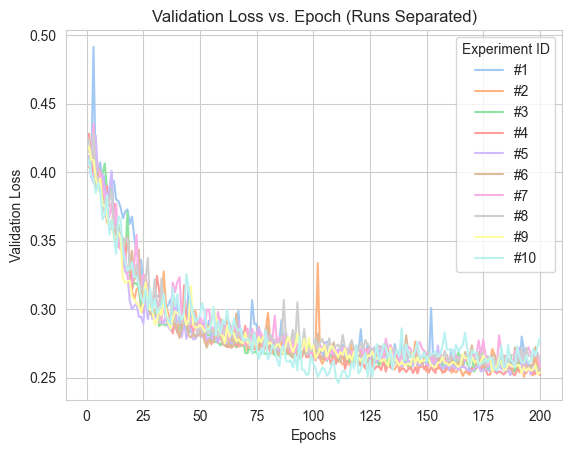

In [40]:
line_graph2_val_diff(noearly_10_train_df)

In [41]:
# Here we show that the test accuracies always retain one pattern, despite hyperparameter variation
def line_graph_test(test_df_raw):
    
    sns.color_palette("pastel")
#     plot = sns.lineplot(data = train_df, y = "Validation Loss", x = "Epoch", hue = "Experiment ID", palette="pastel")
#     plot.set(xlabel = "Epochs", ylabel = "Validation Loss")
    
#     title = "Validation Loss vs. Epoch (Runs Separated)"
#     plot.set_title(title)

    # export_figure(plot, title)
    acc_plot = sns.lineplot(data = test_df_raw, x = "Test-Image Index" , y = "Test Raw Accuracy", hue = "Experiment ID")
    acc_plot.set(xlabel = "Test-Image Index", ylabel = "Inference Accuracies")
    acc_plot.set_title("Test-Image Index vs. Inference Accuracies")

    # save_figure(acc_plot, "Test-Image Index vs. Inference Accuracies")

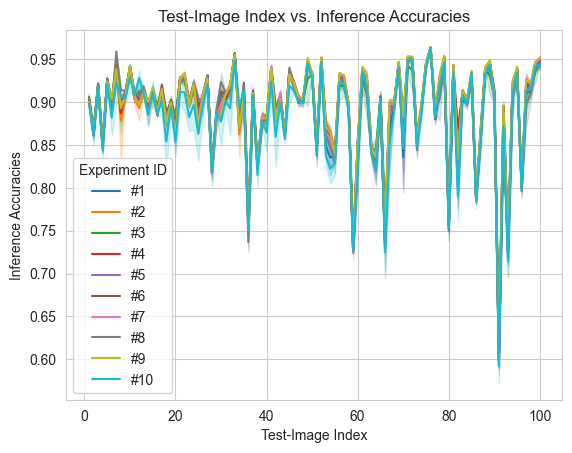

In [42]:
master_test_df = pd.concat([early_5_test_df_raw, noearly_5_test_df_raw, early_10_test_df_raw, noearly_10_test_df_raw, var_test_df_raw], ignore_index=True)
line_graph_test(master_test_df)

In [43]:
# pd.concat([pd.DataFrame(), noearly_10_test_df_raw[noearly_10_test_df_raw["Experiment ID"]=="#1"]])
noearly_10_test_df_raw[noearly_10_test_df_raw['Experiment ID']=="#"+str(1)]

,Experiment ID,Test-Image Index,Test Raw Accuracy
0,#1,1,0.905682
1,#1,2,0.865404
2,#1,3,0.917304
3,#1,4,0.844605
4,#1,5,0.926503
...,...,...,...
95,#1,96,0.800085
96,#1,97,0.923642
97,#1,98,0.920012
98,#1,99,0.942593


In [44]:
def scatterplot_test(test_df_raw):
    sns.color_palette("pastel")
    n = test_df_raw['Experiment ID'].nunique()
    
    experiments_df = pd.DataFrame()
    for i in range(n+1):
        test_df_raw_sorted = test_df_raw[test_df_raw["Experiment ID"]=="#"+str(i)].sort_values(by="Test Raw Accuracy",ascending=False)
        test_df_raw_sorted["test_acc_rank"] = range(1,len(test_df_raw_sorted)+1)
        experiments_df = pd.concat([experiments_df, test_df_raw_sorted])

    acc_plot = sns.scatterplot(data = experiments_df , x = "test_acc_rank" , y = "Test Raw Accuracy", hue = "Experiment ID")
    acc_plot.set(xlabel = "Test Accuracy Rank", ylabel = "Inference Accuracies")
    acc_plot.set_title("Test Accuracy Rank vs. Inference Accuracies")
    
    # save_figure(acc_plot, "Test Accuracy Rank vs. Inference Accuracies")

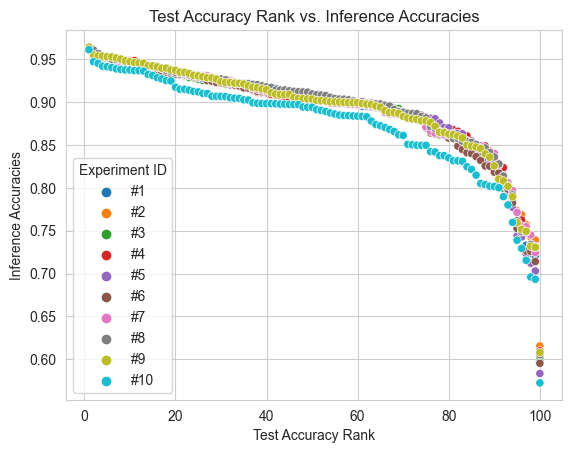

In [45]:
scatterplot_test(noearly_10_test_df_raw)

In [46]:
# Here we pick out the outlier by Test-Image Index
temp = list(noearly_10_test_df_raw[noearly_10_test_df_raw["Test Raw Accuracy"] < 0.8]["Test-Image Index"])
index_dict = dict()
for index in temp:
    if index not in index_dict:
        index_dict[index] = 1
    else:
        index_dict[index] += 1
index_dict

{36: 10, 59: 10, 66: 10, 80: 10, 86: 10, 91: 10, 93: 10, 28: 1, 96: 4, 82: 1}

In [47]:
# FYI

# early_5_cloudmask_file = "{logdir}/9-24-cloudmask_200.log"
# noearly_5_cloudmask_file = "{logdir}/9-26-cloudmask_200.log"
# early_10_cloudmask_file = "{logdir}/10-1-cloudmask_200.log"
# noearly_10_cloudmask_file = "{logdir}/9-29-cloudmask_200.log"
# var_cloudmask_file = "{logdir}/varshitha-6-28-cloudmask_final.log"

In [48]:
def parse_cloudmask(cloudmask_file):
    # Create lists
    time_for_training = []
    time_for_inference = []
    epochs = []
    
    # Read contents in the file
    content = readfile(cloudmask_file).splitlines()
    for line in content:
        split_line = line.split(",")
        for vals in split_line:
            if "CloudMask training" in split_line and 'time_per' in vals.strip():
                time_for_training.append(float(vals.split("=")[1]))
            elif "CloudMask inference" in split_line and 'time_per' in vals.strip():
                time_for_inference.append(float(vals.split("=")[1]))
    
            if "epochs" in vals.strip():
                epochs.append(int(vals.split("=")[1]))
                
    if len(epochs) == len(time_for_training) and len(epochs) == len(time_for_inference):
        # Construct dataframe
        train_time =  pd.DataFrame(columns = ['Experiment ID','Average Time Per Epoch (ms)'])
        test_time =  pd.DataFrame(columns = ['Experiment ID','Average Time Per Epoch (ms)'])
    else:
        print("The Cloudmask file has extra unsuccessful attempt values.")
        return 
    
    for i in range(len(epochs)):
        train_time.loc[len(train_time.index)] = ['#' + str(i+1), time_for_training[i]]
        test_time.loc[len(test_time.index)] = ['#' + str(i+1), time_for_inference[i]]
                
    return (train_time, test_time)

train_time, test_time = parse_cloudmask(noearly_10_cloudmask_file)

In [49]:
test_time

,Experiment ID,Average Time Per Epoch (ms)
0,#1,1.15
1,#2,1.13
2,#3,1.11
3,#4,1.14
4,#5,1.13
5,#6,1.18
6,#7,1.21
7,#8,1.17
8,#9,1.12
9,#10,1.42


In [50]:
def time_graph1(train_time):
    plot = sns.barplot(data = train_time , x = "Experiment ID", y = "Average Time Per Epoch (ms)", palette = "Blues")

    title = "Train Average Time across Experiments"
    plot.set_title(title)

    # export_figure(plot, title)

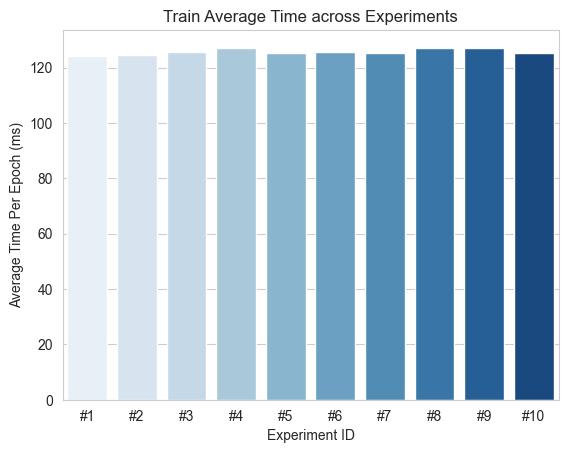

In [51]:
time_graph1(train_time)

In [52]:
def time_graph2(train_time):
    plot = sns.barplot(data = test_time , x = "Experiment ID", y = "Average Time Per Epoch (ms)", palette = "Blues")

    title = "Train Average Time across Experiments"
    plot.set_title(title)

    # export_figure(plot, title)

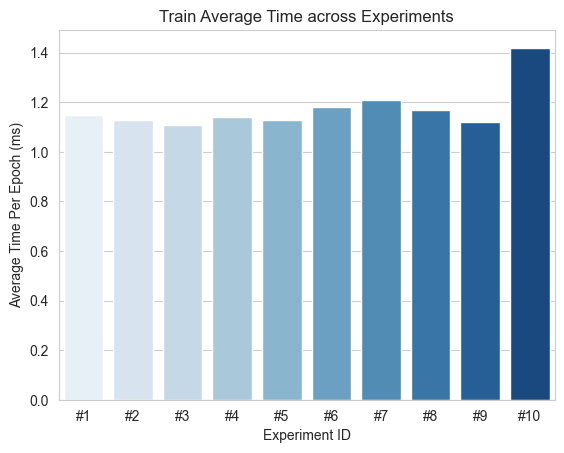

In [53]:
time_graph2(test_time)